In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split


In [2]:
BATCH_SIZE = 16
NUM_WORKERS = 2
SHUFFLE = True
TRAIN_DATA_PATH = 'data/Generic/'
VALIDATION_SPLIT_SIZE = 0.1
IMAGE_X = 50
IMAGE_Y = 50
transform = transforms.Compose([
    transforms.Resize((IMAGE_X,IMAGE_Y)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
def load_dataset_from_folder():
    all_data = ImageFolder(
        root = TRAIN_DATA_PATH,
        transform = transform
    )
    
    classes = all_data.classes
#     print(all_data.class_to_idx)
    validation_size = int(VALIDATION_SPLIT_SIZE * len(all_data))
    train_size = len(all_data) - validation_size
    train_dataset, test_dataset = torch.utils.data.random_split(all_data, [train_size, validation_size])

    training_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=SHUFFLE
    )
    
    validation_dataset_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=SHUFFLE
    )
        
    return training_data_loader,validation_dataset_loader,classes

In [4]:
trainloader,testloader,classes = load_dataset_from_folder()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

 Prev Pause  Prev Others


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,num_channels):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 10*10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 100)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.470
[1,    20] loss: 0.427
[1,    30] loss: 0.449
[1,    40] loss: 0.439
[1,    50] loss: 0.392
[1,    60] loss: 0.504
[1,    70] loss: 0.577
[1,    80] loss: 0.389
[1,    90] loss: 0.358
[1,   100] loss: 0.299
[2,    10] loss: 0.301
[2,    20] loss: 0.261
[2,    30] loss: 0.278
[2,    40] loss: 0.266
[2,    50] loss: 0.275
[2,    60] loss: 0.291
[2,    70] loss: 0.268
[2,    80] loss: 0.287
[2,    90] loss: 0.206
[2,   100] loss: 0.262
Finished Training


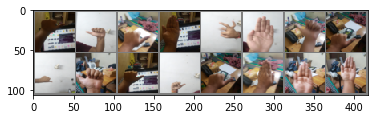

GroundTruth:   Next  Prev  Next Pause Others Pause  Prev  Next  Next  Prev  Next  Next  Next Pause Pause Pause


In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [27]:
outputs = net(images)


In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(16)))



Predicted:   Next Pause  Prev Pause Others Pause  Prev  Next  Next Pause  Next Pause  Next Pause Pause Pause


In [32]:
correct=0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


In [55]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            y_pred.append(predicted[i])
            y_true.append(labels[i])
        c = (predicted == labels).squeeze()
        for i in range(min(16,len(labels))):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of  Next : 83 %
Accuracy of Others : 86 %
Accuracy of Pause : 100 %
Accuracy of  Prev : 77 %


In [49]:
from sklearn.metrics import f1_score 
print(f1_score(y_true, y_pred, average='weighted'))

0.8936039919956058


[[49  3  6  1]
 [ 1 13  1  0]
 [ 0  0 80  0]
 [ 0  0  8 28]] ['Next', 'Others', 'Pause', 'Prev']


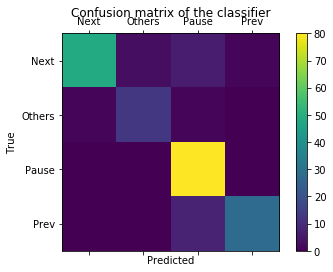

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm,classes)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()